<H1> Extraire les thèmes (topics) de documents via LDA</H1>  

Dans ce notebook nous nous situons dans le cadre de l'apprentisage non supervisé (nous n'avons pas de label de classe sur les donneés) même si, comme nous allons le voir dans la suite, les résultats obtenus peuvent également être utilisés en apprentissage supervisé.  

L'objectif est d'extraire à partir des documents les thèmes ou sujets cachés (*topics*) et pour cela nous allons utiliser le *topic model* LDA (*Latent Dirichlet Allocation* ou *Allocation de Dirichlet Latente*). Il existe de nombreuses classes disponibles pour LDA. Par exemple, scikit learn propose ses propres classes (e.g. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). Dans ce notebook, nous introduisons une nouvelle librairie *gensim* qui outre de nombreuses fonctions ou classes pour manipuler les données textuelles notamment lors des pré-traitements, propose toutes les fonctionnalités pour extraire efficacement les topics. De nombreuses informations sur gensim sont disponibles ici : https://radimrehurek.com/gensim/

## Installation


Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.
 

In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...


#!pip install ..


# ne pas oublier de relancer le kernel du notebook

**Attention pour ce notebook, il faut enlever les commentaires dans la cellule suivante et ne pas oublier de relancer le Kernel (Onglet Exécution/Redémarrer l'environnement d'exécution**

In [49]:
#!pip install pyLDAvis
#!pip install -U gensim
#!pip install --upgrade numpy
#!pip uninstall numpy
#!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # do something here and its warning is suppressed

# librairies générales
import pandas as pd
import re
import time
import numpy as np
import string
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns


# librairies pour LDA

import pyLDAvis


# librairies scikit learn
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


# librairies NLTK
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet


# librairie spacy
import spacy

# librairies de gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim import models




 
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

# chargement spacy en (english)
!python3 -m spacy download en




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-13 11:42:06.769524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-13 11:42:06.769767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-13 11:42:06.769795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [8]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [13]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_FDS
#
# pour une utilisation sur une machine locale changer le chemin ci-dessous et décommenter la ligne
#%cd ./
%ls

/content/gdrive/My Drive/Colab Notebooks/ML_FDS
 aprioriall.py
 AutoencodeurFashionMNIST.h5
 AutoencodeurNoise.h5
 avecscaler.pkl
'Classification de données textuelles.ipynb'
'Classification de données textuellesPourgeneationmodeledansUtilisationModele.ipynb'
 ClassificationImagesAvecCNN.ipynb
'Classification images.ipynb'
 clean_noncomm_use.csv
 CleanText.py
 CNN_ImageGenerator_modelFMnist.h5
 contextIGB.txt
'Copie de Classification images.ipynb'
'Copie de Copie de Classification de données textuelles.ipynb'
 CovidDataset/
 Data_Project/
 dataset_dogs_vs_cats/
 exemple.csv
 exemplenullvalues.csv
 Extraction_de_topics.ipynb
'Extraction de topics (LDA).ipynb'
 ExtractSequentialPatterns.ipynb
 final_modelFMnist.h5
 final_modelTransferLearningFMnist.h5
 firstmodel.pkl
'Fonctionnement dun classifieur.ipynb'
 Gabarit_Notebooks.ipynb
'Ingénierie des données.ipynb'
'Ingénierie des données textuelles.ipynb'
 LesAutoEncodeurs.ipynb
 LesChekpoints.ipynb
 LesGAN.ipynb
'Les word embeddings.

In [14]:
# fonctions utilities (affichage, confusion, etc.)

from MyNLPUtilities import *


## **Extraction de topics : utilisation de LDA**

L'Allocation de Dirichlet Latente (*Latent Dirichlet Allocation*) ou LDA est un modèle probabiliste génératif qui permet de décrire des collections de textes et qui a été introduit par Blei et al. en 2003 (Blei, D. M., A. Y. Ng, et M. I. Jordan (2003). Latent Dirichlet Allocation. Journal of machine learning research : JMLR 3, 993–1022.). Il  fait partie des modèles de type  *topic models* comme L’Analyse Sémantique Latente (LSA - *Latent semantic analysis*) ou l’Analyse Sémantique Latente Probabiliste (PLSA - *Probabilistic latent semantic analysis*),  qui cherchent à découvrir des thématiques cachées (*les topics*) dans les documents. Ainsi le principe est que chaque document peut être décrit par une distribution de topics et chaque topic peut aussi être décrit par une distribution de mots.  Plus précicemment, chaque document est modélisé par un mélange de thèmes générateur des mots du document. LDA est un modèle Bayésien à trois couches (c.f. figure) qui  utilise l’approche Bag of Words pour chaque document $d$ du corpus $D$ défini par ($w_1,...,w_D$) comme un N-uplet de mots, $w_d = (w_1, ..., w_N )$. 
A chaque mot $w(d,n)$ est alors associé un topic représenté par la variable $z_{(d,n)}$. $\Theta _d$ représente la distribution de topics du document $d$. Des hyperparamètres, $\alpha$ et $\eta$, définissent l’*a priori* sur $\Theta$ et $\beta$ où $\beta _k$ décrit la distribution du topic $k$.

<IMG SRC="http://www.lirmm.fr/~poncelet/EGC2021/LDA.png" align="center" >
<center>Le modèle graphique de LDA </center>

Par la suite, nous ne décrivons pas le fonctionnement de LDA mais plutôt sa mise en oeuvre.    

### **Des prétraitements de données** 



Comme pour la classification, il est indispensable de pré-traiter nos données avant de pouvoir appliquer LDA. Dans le notebook "2 - Traitement de données textuelles", nous avons vu que NLTK ou spacy offraient de nombreuses fonctionnalités. Dans cette partie nous introduisons quelques fonctions pratiques issues de la librairie gensim qui permettent aussi de faire des pré-traitements. 

Il existe bien entendu de nombreuses locutions qui sont composées de deux mots (e.g. 'apprentissage automatique', 'machine learning') ou de trois mots (e.g. 'chemin de fer', 'pros and cons'). Nous avons vu précédemment qu'il était possible d'appliquer des n-grammes pour déterminer les mots qui se suivent. Gensim propose différentes fonctions pour pour extraire simplement les bigrams, trigrams etc : 
1. La fonction *Phrase* détecte automatiquement les termes en commun dans un ensemble de phrases (notamment les n-grammes). Les paramètres min_count, threshold correspondent respectivement au nombre minimal d'occurences d'un mot ou d'un ngramme pour être retenu et au seuil de score à atteindre pour former une phrase (le seuil de score par défaut est 10.0, la méthode pour calculer le score par défaut est celle décrite dans https://arxiv.org/abs/1310.4546). Plus le seuil est haut moins il y a de phrases. 
1. La fonction *Phraser* permet d'optimiser la recherche dans la fonction précédente. Généralement elle est utilisée en même temps pour des raisons de performances.


Pour connaitre les différentes classes, fonctions disponibles et les paramètres associés, voir ici https://radimrehurek.com/gensim/models/phrases.html

In [22]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

text =["in software engineering and computer science abstract data type are often used",
        "machine learning is sometimes using abstract data type",
        "an abstract data type is defined by its behavior",
        "machine learning has now become a trending research area",
        "abstract data type may be defined as a class of objects whose logical behavior is defined by a set of values and a set of operations ",
        "an abstract data type is a theoretical concept in computer science"]
# il faut au préalable découper les textes en tokens
#texts.write(' '.join(text).encode('utf-8') + '\n')
tokens = [doc.split(" ") for doc in texts]
print ("tokens", tokens)
# extraction des bigrams (min_count précise qu'ils doivent apparaitre au moins 1 fois)
bigram = Phrases(tokens, min_count=1, delimiter=' ')#threshold=1,delimiter=b' ')
bigram_phraser = Phraser(bigram)

# extraction des trigrams à partir des bigrams précédents
trigram = Phrases(bigram_phraser[tokens], min_count=1,delimiter=' ') 
trigram_phraser = Phraser(trigram)

# Recupération des différents composants des phrases
bigram_tokens = []
for sent in tokens:
    bigram_tokens.append(bigram_phraser[sent])
    bigram_tokens.append(trigram_phraser[bigram[sent]]) 

print ("Les phrases et les bi/trigrammes associés :\n")    
for i in range (len(bigram_tokens)):
    print (bigram_tokens[i])    


tokens [['in', 'software', 'engineering', 'and', 'computer', 'science', 'abstract', 'data', 'type', 'are', 'often', 'used'], ['machine', 'learning', 'is', 'sometimes', 'using', 'abstract', 'data', 'type'], ['an', 'abstract', 'data', 'type', 'is', 'defined', 'by', 'its', 'behavior'], ['machine', 'learning', 'has', 'now', 'become', 'a', 'trending', 'research', 'area'], ['abstract', 'data', 'type', 'may', 'be', 'defined', 'as', 'a', 'class', 'of', 'objects', 'whose', 'logical', 'behavior', 'is', 'defined', 'by', 'a', 'set', 'of', 'values', 'and', 'a', 'set', 'of', 'operations', ''], ['an', 'abstract', 'data', 'type', 'is', 'a', 'theoretical', 'concept', 'in', 'computer', 'science']]
Les phrases et les bi/trigrammes associés :

['in', 'software', 'engineering', 'and', 'computer science', 'abstract data', 'type', 'are', 'often', 'used']
['in', 'software', 'engineering', 'and', 'computer science', 'abstract data', 'type', 'are', 'often', 'used']
['machine learning', 'is', 'sometimes', 'using

A partir du moment où les textes ont été nettoyés, les bi, tri-grammes trouvés, il est nécessaire de définir le vocabulaire (i.e. l'ensemble des mots, composition de mots) sur lequel LDA va apprendre.  

Pour cela il existe la classe *Dictionary* qui va, à partir de l'ensemble des tokens appris précédemment, créer un dictionnaire contenant l'ensemble des mots ainsi qu'un index associé.  
Cet index est utilisé pour transformer le corpus initial.  
Normalement LDA considère uniquement le nombre d'occurrences des mots (*Bag Of Words* cf. notebook "3 - Classification de données textuelles"). Gensim propose via le dictionnaire de transformer le corpus en utilisant la fonction *doc2bow* de la classe Dictionnaire. Il est cependant également possible de transformer le corpus en appliquant un TF-IDF.

In [23]:
import gensim
from gensim import corpora

# bigram_tokens a été obtenu à l'étape précédente 
dictionnaire = gensim.corpora.Dictionary(bigram_tokens)

# pour connaitre le nombre de chaque token 
print("Les différents mots du dictionnaire : \n",dictionnaire.token2id)

# convertion des mots extraits du texte en vecteur de type bag of words
corpus = [dictionnaire.doc2bow(text) for text in bigram_tokens]

print ("\nLa matrice obtenue après tranformation où chaque ligne correspond à un document \n")
for doc in corpus:
    print([[dictionnaire[id], freq] for id, freq in doc])    
    

# conversion via TF-IDF    
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]
print ("\nLa matrice obtenue après tranformation TF-IDF")
for doc in tfidf_model[corpus]:
    print([[dictionnaire[id], np.around(freq,2)] for id, freq in doc])




Les différents mots du dictionnaire : 
 {'abstract data': 0, 'and': 1, 'are': 2, 'computer science': 3, 'engineering': 4, 'in': 5, 'often': 6, 'software': 7, 'type': 8, 'used': 9, 'is': 10, 'machine learning': 11, 'sometimes': 12, 'using': 13, 'an': 14, 'behavior': 15, 'defined by': 16, 'its': 17, 'a': 18, 'area': 19, 'become': 20, 'has': 21, 'now': 22, 'research': 23, 'trending': 24, 'as': 25, 'be': 26, 'class': 27, 'defined': 28, 'logical': 29, 'may': 30, 'objects': 31, 'of': 32, 'operations': 33, 'set of': 34, 'values': 35, 'whose': 36, 'a set of': 37, 'concept': 38, 'theoretical': 39}

La matrice obtenue après tranformation où chaque ligne correspond à un document 

[['abstract data', 1], ['and', 1], ['are', 1], ['computer science', 1], ['engineering', 1], ['in', 1], ['often', 1], ['software', 1], ['type', 1], ['used', 1]]
[['abstract data', 1], ['and', 1], ['are', 1], ['computer science', 1], ['engineering', 1], ['in', 1], ['often', 1], ['software', 1], ['type', 1], ['used', 1]]
[

Maintenant nous proposons en nous inspirant de la fonction *MycleanText* introduite dans le notebook "3 - Classification de données textuelles", une nouvelle fonction *MyCleanTextsforLDA* qui va prendre un ensemble de textes en entrée, les nettoyer, calculer les bigrams, déterminer le vocabulaire (dictionnaire) et retourner deux corpus (un avec uniquement un bag of words, l'autre en utilisant TF-IDF).

In [30]:
import re
import spacy
import gensim
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim import models
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#nlp = spacy.load('en', disable=['parser', 'ner'])

def MyCleanTextsforLDA(texts,
                      min_count=1, # nombre d'apparitions minimale pour un bigram
                      threshold=2, 
                      no_below=1, # nombre minimum d'apparitions pour être dans le dictionnaire
                      no_above=0.5, # pourcentage maximal (sur la taille totale du corpus) pour filtrer
                      stop_words=stop_words
                      ):
    
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    sentences=texts.copy()
    
    # suppression des caractères spéciaux
    sentences = [re.sub(r'[^\w\s]', ' ', str(sentence)) for sentence in sentences]
    # suppression de tous les caractères uniques
    sentences = [re.sub(r'\s+[a-zA-Z]\s+', ' ', str(sentence)) for sentence in sentences]
    # substitution des espaces multiples par un seul espace
    sentences = [re.sub(r'\s+', ' ', str(sentence), flags=re.I) for sentence in sentences]
    
    # conversion en minuscule et split des mots dans les textes
    sentences = [sentence.lower().split() for sentence in sentences]
    
    # utilisation de spacy pour ne retenir que les allowed_postags
    texts_out = []
    for sent in sentences:
        if len(sent) < (nlp.max_length): # si le texte est trop grand
            doc = nlp(" ".join(sent)) 
            texts_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags]))
        else: 
            texts_out.append(sent)    
    sentences=texts_out 
    
    # suppression des stopwords
    words =[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in sentences]
    
    
    # recherche des bigrammes
    bigram = Phrases(words, min_count, threshold,delimiter=' ')
    bigram_phraser = Phraser(bigram)
    
    
    # sauvergarde des tokens et des bigrammes
    bigram_token = []
    for sent in words:
        bigram_token.append(bigram_phraser[sent])
        
    
    # creation du vocabulaire
    dictionary = gensim.corpora.Dictionary(bigram_token)

    
    # il est possible de filtrer des mots en fonction de leur occurrence d'apparitions
    #dictionary.filter_extremes(no_below, no_above)
    # et de compacter le dictionnaire
    # dictionary.compactify()
    corpus = [dictionary.doc2bow(text) for text in bigram_token]
    
    # recuperaction du tfidf plutôt que uniquement le bag of words
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    return corpus, corpus_tfidf, dictionary, bigram_token




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Construction du modèle LDA** 

  

A part le nombre de topics à spécifier, nous disposons, à présent, avec le corpus et le dictionnaire de tout ce qu'il faut pour construire un modèle LDA.  

Gensim propose différentes classes pour obtenir le modèle :  *LdaModel* ou *LdaMulticore*. Le second offre la possibilité de répartir des tâches sur différents CPU et est donc plus rapide.  

Les principaux paramètres pour LdaMulticore$^*$ sont les suivants : 
1. *corpus* qui correspond au corpus représenté sous la forme d'une matrice (il s'agit du corpus que nous avons transformé précédemment).
1. *num_topics* est un entier qui correspond au nombre de topics à extraire du corpus d'apprentissage.
1. *id2word* correspond au dictionnaire ou vocabulaire de mots ou combinaisons de mots utilisés (il s'agit du dictionnaire que nous avons initialisé précédemment). 
1. *chunksize* correspond au nombre de documents à utiliser à chaque étape d'entraînement du modèle.
1. *alpha* et *eta* qui sont des hyperparamètres qui considèrent la rareté des topics. Par défaut leur valeur est de 1.0.
1. *update_every* détermine la fréquence à laquelles les paramètres du modèle doivent être mis à jour.
1. *passe* correspond au nombre total de passes d'entraînement.

De plus amples informations sur les paramètres de LdaModel ou de LdaMulticore sont disponibles ici :  https://radimrehurek.com/gensim/models/ldamodel.html
https://radimrehurek.com/gensim/models/ldamulticore.html?highlight=multicore#module-gensim.models.ldamulticore  

$^*$ les paramètres indiqués sont similaires pour LdaModel.

Considérons le jeu de données des opinions imdb, amazon et yelp que nous avons vu dans les notebooks précédents : 

In [26]:
!wget https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv

--2023-02-13 11:20:49--  https://www.lirmm.fr/~poncelet/EGC2021/ReviewsLabelled.csv
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222119 (217K) [text/csv]
Saving to: ‘ReviewsLabelled.csv.1’

ReviewsLabelled.csv 100%[===================>] 216.91K   297KB/s    in 0.7s    

2023-02-13 11:20:52 (297 KB/s) - ‘ReviewsLabelled.csv.1’ saved [222119/222119]



In [27]:
df_donnees = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], 
                 header=0,sep='\t', encoding='utf8')

print (df_donnees.shape)
display (df_donnees)

(3000, 3)


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp
2996,Appetite instantly gone.,0,yelp
2997,Overall I was not impressed and would not go b...,0,yelp
2998,"The whole experience was underwhelming, and I ...",0,yelp


Par la suite, nous ne nous interessons qu'aux topics des avis de imdb.

In [28]:
# selection des données de imdb
df_source=df_donnees[(df_donnees['source']=='imdb')]
df_source.reset_index(drop = True, inplace = True) 
print (df_source.shape)


(1000, 3)


Nous pré-traitons les données à l'aide de la fonction MyCleanTextsforLDA. Elle retourne le corpus transformé en BoW (*corpus*), transformé en TF-IDF (*corpus_tfidf*), le dictionnaire et l'ensemble des tokens et bigrams.

In [31]:
stop_words = stopwords.words('english')

# enrichissement des stopwords 
stop_words.extend(['always','try','go','get','make','would','really',
                  'like','came','got'])
corpus, corpus_tfidf, dictionary, bigram_token=MyCleanTextsforLDA(df_source.sentence,stop_words=stop_words)



Dans un premier temps nous considérons le corpus de type bag of words :

In [32]:
import gensim
from gensim import models

num_topics=7 # nombre de topics
num_words=10 # nombre de mots par topics


lda_model_bow = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=num_topics,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, 
                            passes=10,
                            random_state=100,
                           eval_every = 1,
                           per_word_topics=True)


print ("Affichage des ",num_topics," différents topics pour le corpus BOW :\n")
for idx, topic in lda_model_bow.print_topics(-1,num_words):
    print('Topic: {} Word: {}'.format(idx, topic))




Affichage des  7  différents topics pour le corpus BOW :

Topic: 0 Word: 0.025*"film" + 0.011*"movie" + 0.010*"suck" + 0.010*"character" + 0.009*"bad" + 0.008*"way" + 0.007*"much" + 0.007*"little" + 0.006*"even" + 0.006*"whole"
Topic: 1 Word: 0.038*"bad" + 0.026*"film" + 0.023*"movie" + 0.011*"funny" + 0.008*"take" + 0.008*"time" + 0.007*"awful" + 0.006*"work" + 0.006*"scene" + 0.006*"script"
Topic: 2 Word: 0.013*"movie" + 0.012*"recommend" + 0.010*"thing" + 0.009*"drama" + 0.008*"watch" + 0.008*"enjoy" + 0.007*"scene" + 0.006*"show" + 0.006*"short" + 0.006*"plot line"
Topic: 3 Word: 0.023*"film" + 0.022*"movie" + 0.014*"character" + 0.009*"great" + 0.009*"story" + 0.008*"see" + 0.007*"animation" + 0.007*"time" + 0.007*"know" + 0.007*"also"
Topic: 4 Word: 0.025*"well" + 0.015*"good" + 0.013*"film" + 0.010*"movie" + 0.010*"character" + 0.009*"love" + 0.009*"easy" + 0.008*"think" + 0.007*"see" + 0.006*"waste time"
Topic: 5 Word: 0.024*"see" + 0.015*"movie" + 0.011*"boring" + 0.011*"film"

### **Evaluation de la qualité des topics extraits**



La meilleure évaluation de la qualité des topics extraits reste ... l'évaluation humaine. Toutefois il existe deux mesures qui peuvent être utilisées  : 
1. La *perplexité* qui mesure la capacité d’un modèle probabiliste à généraliser, i.e. comment un modèle se comporte avec de nouvelles données qu'il n'a pas vu auparavant. Il est bien entendu préférable que la perplexité soit petite.  
1. La *cohérence* qui évalue la cohérence entre les topics déduits du  modèle en combinant un certain nombre de mesures. Il existe en effet de nombreuses mesures de cohérences. Par exemple, la mesure *C_v* est basée sur une fenêtre glissante, une segmentation en un seul ensemble des premiers mots et une mesure de confirmation indirecte qui utilise des informations mutuelles ponctuelles normalisées (NPMI) et la similitude cosinus. Il est bien entendu préférable d'avoir une forte valeur. 



In [33]:
print ("Calcul de la cohérence et de la perplexité du modèle pour le corpus BOW : ")
# cohérence
coherence_model_lda = CoherenceModel(model=lda_model_bow, texts=bigram_token, dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCohérence : ', coherence_lda)

# perplexité
print('\nPerplexité : ', lda_model_bow.log_perplexity(corpus))  




Calcul de la cohérence et de la perplexité du modèle pour le corpus BOW : 

Cohérence :  0.5184420472986456

Perplexité :  -8.305298141262089


<font color=red>Exercice :</font> précédemment nous avons extrait la matrice du corpus obtenue via un TF-IFD, i.e. *corpus_tfidf*. Rechercher le modèle LDA associé à ce corpus, afficher les différents topics et évaluer la perplexité et la cohérence. Vous pouvez faire varier le nombre de topics et le nombre de mots affichés (*num_topics*, 
Comparer avec les résultats obtenus sans appliquer de TF-IDF. Est-ce que les topics vous semblent mieux décrire les documents ? 

<font color=blue>Solution :</font> 

In [34]:
#il suffit d'appliquer LdaMulticore sur corpus_tfidf.
lda_model_tfidf = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_tfidf,
                           num_topics=num_topics,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, 
                           passes=10,
                           random_state=100,
                           eval_every = 1,
                           per_word_topics=True)

print ("Affichage des ",num_topics," différents topics pour le corpus TF-IDF :")

for idx, topic in lda_model_tfidf.print_topics(-1,num_words):
    print('Topic: {} Word: {}'.format(idx, topic))

coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=bigram_token, dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda_tfidf.get_coherence()
print('Cohérence  : ', coherence_lda)

print('Perplexité : ', lda_model_tfidf.log_perplexity(corpus_tfidf))  

Affichage des  7  différents topics pour le corpus TF-IDF :
Topic: 0 Word: 0.009*"film" + 0.008*"suck" + 0.005*"movie" + 0.005*"way" + 0.004*"dialogue" + 0.004*"character" + 0.003*"script" + 0.003*"second" + 0.003*"plain" + 0.003*"bad"
Topic: 1 Word: 0.016*"bad" + 0.012*"movie" + 0.011*"awful" + 0.009*"funny" + 0.007*"give" + 0.005*"film" + 0.005*"rent" + 0.005*"time" + 0.004*"want" + 0.004*"story line"
Topic: 2 Word: 0.010*"recommend" + 0.008*"watch" + 0.007*"avoid cost" + 0.006*"enjoy" + 0.006*"movie" + 0.005*"film" + 0.004*"scene" + 0.004*"good" + 0.004*"easy" + 0.004*"even"
Topic: 3 Word: 0.007*"movie" + 0.006*"great" + 0.005*"film" + 0.005*"character" + 0.004*"actor" + 0.004*"forget" + 0.004*"story" + 0.004*"see" + 0.004*"time" + 0.004*"unbelievable"
Topic: 4 Word: 0.008*"waste time" + 0.007*"well" + 0.007*"love" + 0.007*"good" + 0.007*"right" + 0.006*"think" + 0.005*"film" + 0.005*"good film" + 0.005*"see movie" + 0.005*"keep"
Topic: 5 Word: 0.010*"boring" + 0.007*"see film" + 0.

### **Quel est le topic dominant ?**



Maintenant que nous savons calculer la cohérence et la perplexité du modèle, il est interessant de pouvoir déterminer pour un document quel est le topic qui est le plus dominant. En fait l'application du modèle appris sur un document retourne un vecteur contenant pour chacun des topics le pourcentage d'appartenance de ce topic dans le document :  



In [35]:

def dominant_topic(model,corpus,num_topics):
    # recuperation du vecteur associé
    # creation d'un dictionnaire pour stocker les résultats
    topic_dictionary = {i: [] for i in range(num_topics)} 
    topic_probability_scores = model.get_document_topics(corpus,minimum_probability=0.000)
    if len(topic_probability_scores) ==1 : # il y a plusieurs predictions on recupere la premiere
        row=topic_probability_scores[0]
    else: # on concatene les predictions
        tab=[]
        for j in range (len(topic_probability_scores)):
            tab.append(topic_probability_scores[j])
        row=tab  
    # parcours des différents topics
    for (topic_num, prop_topic) in row:
            topic_dictionary[topic_num].append(prop_topic)
    # tri pour avoir le plus grand en premier
    list_proba=topic_dictionary
    topic_dictionary=sorted(topic_dictionary, key=topic_dictionary.get,reverse = True)
    return topic_dictionary, list_proba        


print ("Le premier document pré-traité : ",bigram_token[0])

# recuperation du topic dominant
topic_dictionary,list_proba=dominant_topic(lda_model_bow,corpus[0],num_topics)
                                      
print ("le topic dominant pour le model BOW est : ",topic_dictionary[0])     
print ("la liste des topics par ordre d'importance : ",topic_dictionary)
print ("les probabilités associées  : ",list_proba)

topic_dictionary,list_proba=dominant_topic(lda_model_tfidf,corpus[0],num_topics)
print ("le topic dominant pour le model TF-IDF est : ",topic_dictionary[0])       
print ("la liste des topics par ordre d'importance : ",topic_dictionary)
print ("les probabilités associées  : ",list_proba)


Le premier document pré-traité :  ['slow move', 'aimless', 'movie', 'distressed', 'drift', 'young', 'man']
le topic dominant pour le model BOW est :  1
la liste des topics par ordre d'importance :  [1, 0, 2, 6, 5, 3, 4]
les probabilités associées  :  {0: [0.017987335], 1: [0.89251864], 2: [0.017927608], 3: [0.017882168], 4: [0.01787818], 5: [0.01788687], 6: [0.017919203]}
le topic dominant pour le model TF-IDF est :  1
la liste des topics par ordre d'importance :  [1, 3, 2, 6, 0, 4, 5]
les probabilités associées  :  {0: [0.017888358], 1: [0.89232063], 2: [0.018000552], 3: [0.01813127], 4: [0.017879691], 5: [0.0178739], 6: [0.01790565]}


La fonction *format_topics_sentences* permet de créer à partir du corpus de document un dataframe qui contient à la fois le topic dominant, i.e. celui qui représente le mieux le document, la liste des mots associés au topic ainsi que sa contribution.

In [36]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialisation du dataframe de sortie
    sent_topics_df = pd.DataFrame()
    
    # Recherche le topic dominant pour chaque document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Donne le topic dominant, le pourcentage de contribution 
        # et les mots clés pour chaque document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => topic dominant
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['topic_dominant', 'pourcentage_contrib', 'topic_keywords']

    # Ajout du texte original à la fin de la sortie
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [37]:
print ("\nLes différents topics pour le modèle BOW : ")
for i,topic in lda_model_bow.show_topics(formatted=True, num_topics=num_topics, num_words=num_words):
    print(str(i)+": "+ topic)
    
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_bow, corpus=corpus, texts=df_source.sentence)


display(df_topic_sents_keywords)




Les différents topics pour le modèle BOW : 
0: 0.025*"film" + 0.011*"movie" + 0.010*"suck" + 0.010*"character" + 0.009*"bad" + 0.008*"way" + 0.007*"much" + 0.007*"little" + 0.006*"even" + 0.006*"whole"
1: 0.038*"bad" + 0.026*"film" + 0.023*"movie" + 0.011*"funny" + 0.008*"take" + 0.008*"time" + 0.007*"awful" + 0.006*"work" + 0.006*"scene" + 0.006*"script"
2: 0.013*"movie" + 0.012*"recommend" + 0.010*"thing" + 0.009*"drama" + 0.008*"watch" + 0.008*"enjoy" + 0.007*"scene" + 0.006*"show" + 0.006*"short" + 0.006*"plot line"
3: 0.023*"film" + 0.022*"movie" + 0.014*"character" + 0.009*"great" + 0.009*"story" + 0.008*"see" + 0.007*"animation" + 0.007*"time" + 0.007*"know" + 0.007*"also"
4: 0.025*"well" + 0.015*"good" + 0.013*"film" + 0.010*"movie" + 0.010*"character" + 0.009*"love" + 0.009*"easy" + 0.008*"think" + 0.007*"see" + 0.006*"waste time"
5: 0.024*"see" + 0.015*"movie" + 0.011*"boring" + 0.011*"film" + 0.009*"real" + 0.007*"play" + 0.006*"act" + 0.006*"recommend" + 0.006*"even" + 0.0

,topic_dominant,pourcentage_contrib,topic_keywords,sentence
0,1.0,0.8925,"bad, film, movie, funny, take, time, awful, wo...","A very, very, very slow-moving, aimless movie ..."
1,5.0,0.7747,"see, movie, boring, film, real, play, act, rec...",Not sure who was more lost - the flat characte...
2,6.0,0.9493,"movie, film, watch, love, still, bad, simply, ...",Attempting artiness with black & white and cle...
3,0.0,0.7855,"film, movie, suck, character, bad, way, much, ...",Very little music or anything to speak of.
4,6.0,0.6232,"movie, film, watch, love, still, bad, simply, ...",The best scene in the movie was when Gerardo i...
...,...,...,...,...
995,1.0,0.8774,"bad, film, movie, funny, take, time, awful, wo...",I just got bored watching Jessice Lange take h...
996,1.0,0.9047,"bad, film, movie, funny, take, time, awful, wo...","Unfortunately, any virtue in this film's produ..."
997,0.0,0.7142,"film, movie, suck, character, bad, way, much, ...","In a word, it is embarrassing."
998,4.0,0.3913,"well, good, film, movie, character, love, easy...",Exceptionally bad!


A partir de ce dataframe il est possible de connaître le document le plus représentatif du topic : 

In [38]:

# groupement par topic dominant 
sent_topics_gbtp = df_topic_sents_keywords.groupby('topic_dominant')

sentence_for_topics=pd.DataFrame()
# concaténation en fonction des pourcentage de contribution
for i, grp in sent_topics_gbtp:
    sentence_for_topics = pd.concat([sentence_for_topics, 
                                grp.sort_values(['pourcentage_contrib'], ascending=[0]).head(1)], 
                                            axis=0)

sentence_for_topics.reset_index(drop=True, inplace=True)
sentence_for_topics.columns = ['topic_num', "pourcentage_contrib", "topic_keywords", "text"]

display(sentence_for_topics)


,topic_num,pourcentage_contrib,topic_keywords,text
0,0.0,0.9774,"film, movie, suck, character, bad, way, much, ...","This is a masterful piece of film-making, with..."
1,1.0,0.9627,"bad, film, movie, funny, take, time, awful, wo...",The film deserves strong kudos for taking this...
2,2.0,0.9656,"movie, recommend, thing, drama, watch, enjoy, ...",The attempts at humor were pitiful and story i...
3,3.0,0.9656,"film, movie, character, great, story, see, ani...",The use of slow-motion needlessly repeats itse...
4,4.0,0.9642,"well, good, film, movie, character, love, easy...",A cheap and cheerless heist movie with poor ch...
5,5.0,0.9627,"see, movie, boring, film, real, play, act, rec...",About 30 minutes of footage is wasted to show ...
6,6.0,0.9704,"movie, film, watch, love, still, bad, simply, ...",This movie is excellent!Angel is beautiful and...


ou bien la répartition des documents dans les topics : 

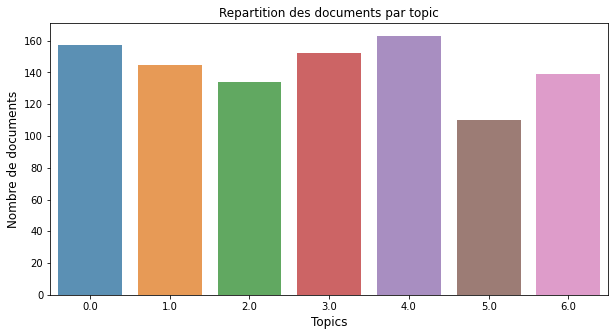

In [39]:
# nombre de documents par topics
topic_counts = df_topic_sents_keywords['topic_dominant'].value_counts()

# affichage
plt.figure(figsize=(10,5))
ax=sns.barplot(x=topic_counts.index,y=topic_counts.values,  alpha=0.8)
plt.title('Repartition des documents par topic')
plt.ylabel('Nombre de documents', fontsize=12)
plt.xlabel('Topics', fontsize=12)
plt.show()


### **Prediction des topics pour des nouveaux documents** 



Il est tout à fait possible de faire de la prédiction de topics appris pour un nouveau document. Pour cela il est indispensable de d'abord le transformer en vecteur qui puisse être utilisé par le modèle. En outre, si des pré-traitements ont été effectués, ces derniers doivent également être réalisés.  

Le principe général est tout simplement d'appliquer le modèle sur le document qui a été transformé. Cette action retourne un vecteur qui contient pour chaque topic sa propabilité de participation. 

In [40]:
mytext = ["This is a new text that I have never seen before "]

print ("transformation du texte :", mytext)

# application des pré-traitements pour appliquer les pré-traitements et transformer le texte en vecteur
my_corpus, my_corpus_tfidf, my_dictionary, my_bigram_token=MyCleanTextsforLDA(mytext)

print ("la matrice obtenue après transformation : ", my_corpus)
# il suffit alors d'appliquer le modèle appris sur le texte transformé
# ici nous considérons la matrice (my_corpus) et le modèle précédent : lda_model_bow
vector=lda_model_bow[my_corpus]

print ("les probabilités pour chaque topic : ", vector[0])

# il est possible de déterminer le topic dominant à l'aide la fonction dominant_topic 

topic_dictionary,list_proba=dominant_topic(lda_model_bow,my_corpus,num_topics)
                                      
print ("le topic dominant pour le model BOW sur un nouveau texte : ",topic_dictionary[0])     
print ("la liste des topics par ordre d'importance : ",topic_dictionary)
print ("les probabilités associées  : ",list_proba)


transformation du texte : ['This is a new text that I have never seen before ']
la matrice obtenue après transformation :  [[(0, 1), (1, 1), (2, 1), (3, 1)]]
les probabilités pour chaque topic :  ([(0, 0.028957548), (1, 0.8279374), (2, 0.02858124), (3, 0.028606748), (4, 0.028612604), (5, 0.028630506), (6, 0.02867388)], [(0, [1]), (1, [1]), (2, [1]), (3, [1])], [(0, [(1, 0.99945265)]), (1, [(1, 0.9994526)]), (2, [(1, 0.9999569)]), (3, [(1, 0.996759)])])
le topic dominant pour le model BOW sur un nouveau texte :  1
la liste des topics par ordre d'importance :  [1, 0, 6, 5, 4, 3, 2]
les probabilités associées  :  {0: [0.028956922], 1: [0.8279381], 2: [0.02858124], 3: [0.028606748], 4: [0.028612604], 5: [0.028630504], 6: [0.02867388]}


### **Sauvegarde d'un modèle**



Il est bien entendu possible de sauvegarder un modèle pour pouvoir le réutiliser. Par contre il est peut être aussi utile de sauvegarder le corpus transformé ainsi que les dictionnaires.

In [41]:
# pour sauvegarder le modèle
lda_model_bow.save('firstlda_model_bow.model')

# pour charger le modèle
lda_new = gensim.models.LdaMulticore.load('firstlda_model_bow.model')

# test sur un texte non lu, voir section précente
mytext = ["This is another new text that I have never seen before even if I have already seen new texts"]
my_corpus, my_corpus_tfidf, my_dictionary, my_bigram_token=MyCleanTextsforLDA(mytext)

topic_dictionary,list_proba=dominant_topic(lda_new,my_corpus,num_topics)
                                      
print ("le topic dominant à partir du modèle sauvegardé sur un nouveau texte : ",topic_dictionary[0])     
print ("la liste des topics par ordre d'importance : ",topic_dictionary)
print ("les probabilités associées  : ",list_proba)

le topic dominant à partir du modèle sauvegardé sur un nouveau texte :  1
la liste des topics par ordre d'importance :  [1, 0, 6, 3, 5, 4, 2]
les probabilités associées  :  {0: [0.2178113], 1: [0.6927184], 2: [0.017876346], 3: [0.017894983], 4: [0.017882379], 5: [0.017893404], 6: [0.017923163]}


### **Recherche automatique des meilleurs paramètres**



Il est bien évident possible de trouver les meilleurs paramètres, notamment alpha, beta et le nombre de topics afin d'obtenir le meilleur modèle. Dans ce notebook nous avons utilisé la librairie gensim et notamment la classe LdaMulticore qui est plus performante que celles proposées par scikit learn (LatentDirichletAllocation). Il est donc assez compliqué d'appliquer GridSearhCV. Néanmoins nous pouvons faire un traitement assez similaire.    

La cellule ci-dessous propose la fonction MyGridSearchLda. Cette dernière est largement inspirée de https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0  
Elle peut être bien entendue améliorée en intégrant par exemple d'autres paramètres, différents découpages du jeu de données et évaluation d'un jeu de test/apprentissage différent dans une approche "à la cross validation". Elle a ici plus un but pédagogique pour rapidement tester les paramètres.

In [42]:
# ce code est inspiré de 
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
def compute_coherence_values(corpus, dictionary, listtokens, k, alpha, eta):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           eta=eta,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=listtokens, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

def MyGridSearchLda (corpus,listtokens,dictionnary,nb_topics,alpha,beta,verbose=1):
        
    grid = {}
    model_results = {'topics': [],
                     'alpha': [],
                     'eta': [],
                     'coherence': []
                    }
    # iteration sur le nombre de topics
    for k in nb_topics:
        # iteration sur les valeurs d'alpha
        for a in alpha:
            # iteration sur les valeurs de eta
            for e in eta:
                # calcul du score de coherence
                cv = compute_coherence_values(corpus=corpus, 
                                              dictionary=dictionary,
                                              listtokens=listtokens,
                                              k=k, alpha=a, eta=e)
                if verbose==1:
                    print ('topics:', k, ' alpha: %0.3f  eta: %0.3f  coherence: %0.3f'%(a,e,cv))
                        
                # sauvegarde des résultats
                model_results['topics'].append(k)
                model_results['alpha'].append(a)
                model_results['eta'].append(e)
                model_results['coherence'].append(cv)
                  
    df_result=pd.DataFrame(model_results)
    df_result = df_result.sort_values('coherence',ascending=False)
    df_result.reset_index(drop=True, inplace=True)
    return df_result



In [43]:
# variation du nombre de topics
min_topics = 7
max_topics = 10
step_size = 1
nb_topics = range(min_topics, max_topics, step_size)
# variation d'alpha
alpha = list(np.arange(0.01, 1, 0.3))
# variation de eta
eta = list(np.arange(0.01, 1, 0.3))

print ("Extraction des meilleurs paramètres pour le corpus via BOW : ")
df_result=MyGridSearchLda (corpus,bigram_token,dictionary,nb_topics,alpha,eta,verbose=1)  
display (df_result)

Extraction des meilleurs paramètres pour le corpus via BOW : 
topics: 7  alpha: 0.010  eta: 0.010  coherence: 0.550
topics: 7  alpha: 0.010  eta: 0.310  coherence: 0.552
topics: 7  alpha: 0.010  eta: 0.610  coherence: 0.536
topics: 7  alpha: 0.010  eta: 0.910  coherence: 0.525
topics: 7  alpha: 0.310  eta: 0.010  coherence: 0.616
topics: 7  alpha: 0.310  eta: 0.310  coherence: 0.550
topics: 7  alpha: 0.310  eta: 0.610  coherence: 0.551
topics: 7  alpha: 0.310  eta: 0.910  coherence: 0.573
topics: 7  alpha: 0.610  eta: 0.010  coherence: 0.606
topics: 7  alpha: 0.610  eta: 0.310  coherence: 0.548
topics: 7  alpha: 0.610  eta: 0.610  coherence: 0.543
topics: 7  alpha: 0.610  eta: 0.910  coherence: 0.522
topics: 7  alpha: 0.910  eta: 0.010  coherence: 0.612
topics: 7  alpha: 0.910  eta: 0.310  coherence: 0.525
topics: 7  alpha: 0.910  eta: 0.610  coherence: 0.529
topics: 7  alpha: 0.910  eta: 0.910  coherence: 0.511
topics: 8  alpha: 0.010  eta: 0.010  coherence: 0.577
topics: 8  alpha: 0.

,topics,alpha,eta,coherence
0,9,0.31,0.01,0.640277
1,9,0.91,0.01,0.633508
2,9,0.61,0.01,0.630639
3,8,0.61,0.01,0.627827
4,8,0.31,0.01,0.618158
5,7,0.31,0.01,0.616419
6,8,0.91,0.01,0.615489
7,7,0.91,0.01,0.612198
8,7,0.61,0.01,0.606202
9,9,0.01,0.01,0.585593


<font color=red>Exercice :</font> à partir des résultats précédents, appliquer les meilleurs paramètres pour le modèle LDA sur le corpus obtenu via BOW afin d'obtenir les topics et les mots associés. Comparer les résultats avec l'exécution précédente. 


<font color=blue>Solution :</font> 

In [ ]:
# les résultats sont actuellement stockés dans le dataframe df_result. 
# Il suffit de récupérer le nombre de topics, alpha et eta à partir de ce dernier et de relancer LdAMulticore.
num_topic_best=df_result['topics'][0]
alpha_best=df_result['alpha'][0]
eta_best=df_result['eta'][0]

lda_model_bow_best = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=num_topic_best,
                           alpha=alpha_best,
                           eta=eta_best,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, # Nombre de coeurs - 1
                           passes=10,
                            random_state=100,
                           eval_every = 1,
                           per_word_topics=True)



print ("Affichage des ",num_topic_best," différents topics pour le corpus BOW :")
for idx, topic in lda_model_bow_best.print_topics(-1,num_words):
    print('Topic: {} Word: {}'.format(idx, topic))
    
# cohérence
coherence_model_lda = CoherenceModel(model=lda_model_bow_best, texts=bigram_token, dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Cohérence : ', coherence_lda)

# perplexité
print('Perplexité : ', lda_model_bow_best.log_perplexity(corpus))  

La fonction suivante illustre comment obtenir également le meilleur nombre de topics. Elle est assez simple car applique sur un intervalle de valeur le modèle et calcule la cohérence associée. Elle peut bien entendu être étendue en intégrant une variation de paramètres différents comme nous l'avons vu précédemment. Par contre ce traitement est forcément .... long (Cf. l'application de GridSearchCV).

In [45]:

def get_best_coherence_values(corpus, dictionary, listtokens, start=5, stop=15, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
        coherence_model_lda = CoherenceModel(model=lda_model, texts=listtokens, dictionary=dictionary, coherence='c_v')
        model_list.append(lda_model)
        coherence_values.append(coherence_model_lda.get_coherence())
    return model_list, coherence_values



In [46]:
# test sur un intervalle de 6 à 15 en utilisant le corpus Bow 
start=6
stop=15
step=1
model_list, coherence_values = get_best_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        listtokens=bigram_token, 
                                                        start=start, stop=stop, step=step)

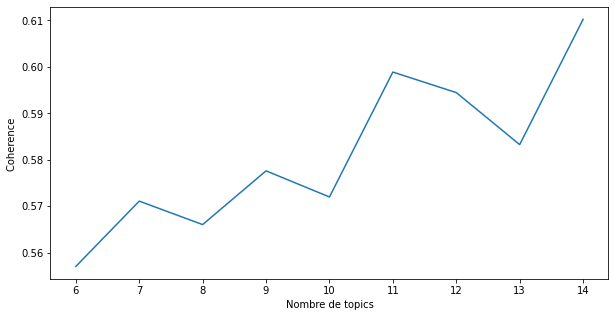

In [47]:
# affichage du graphe associé à la recherche du nombre de topics
plt.figure(figsize=(10,5))
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de topics")
plt.ylabel("Coherence ")
#plt.legend(("Valeurs de cohérencescoherence_values"), loc='best')
plt.show()

## **Visualisation interactive des topics**



La librairie pyLDAvis propose de pouvoir visualiser de manière interactive les différents topics obtenus. Il est possible de les afficher dans le notebook ou bien de sauvegarder une page html.  


Plus d'informations sur la librairie pyLDAvis ici : https://pyldavis.readthedocs.io/en/latest/readme.html  

Il suffit dans un premier temps de préparer les données à l'aide de gensimvis. 

In [52]:
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
visu_data = gensimvis.prepare(lda_model_bow, corpus, dictionary)

Pour afficher les données et les sauvegarder sur une page html :


In [53]:
# save the results to html file
filename='my_first_lda.html'
my_lda = open(filename, 'w')
pyLDAvis.save_html(visu_data,my_lda)


<font color=red>Exercice :</font> aller sur le répertoire courant et ouvrir dans un navigateur le fichier my_first_lda.html.

Pour afficher le résultat directement dans le notebook :

In [54]:
pyLDAvis.display(visu_data)

<font color=red>Exercice :</font> nous avons réalisé plusieurs expérimentations notamment en utilisant bag of words ou tf-idf. Afficher les deux corpus pour pouvoir les comparer à l'aide de la visualisation de pyLDAvis. 

<font color=blue>Solution :</font> 

In [55]:
# il suffit de préparer les données sur les deux modèles et de les visualiser ou les sauvegarder dans des fichiers html. 
# Attention si l'affichage se fait dans le notebook, il faut les mettre dans deux cellules différentes.  
visu_data_bow = gensimvis.prepare(lda_model_bow, corpus, dictionary)
visu_data_tfidf=gensimvis.prepare(lda_model_tfidf,corpus_tfidf,dictionary)
pyLDAvis.display(visu_data_bow)

In [56]:
pyLDAvis.display(visu_data_tfidf)

### **Utilisation de LDA pour faire de la classification supervisée**



En introduction, nous avons précisé que LDA était une approche de classification non supervisée. En effet, il n'existe pas de label de classes et nous avons vu que nous pouvions pour les différents documents leur attribuer des topics et même un topic dominant. En fait il est tout à fait possible de considérer LDA comme un moyen de réduire les dimensions (un peu comme une ACP) et donc de pouvoir utiliser les différents mots des topics comme représentant un document plutôt que le texte associé. Par la suite, il suffira d'utiliser ces mots clés pour pouvoir appliquer un algorithme de classificatin supervisé.

Dans cette section, nous montrons comment il est possible d'utiliser les topics pour classer les différentes opinions sur imdb, amazon et yelp.

In [57]:
# chargement des données
df_all = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], 
                 header=0,sep='\t', encoding='utf8')

print (df_all.shape)
display (df_donnees)


(3000, 3)


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp
2996,Appetite instantly gone.,0,yelp
2997,Overall I was not impressed and would not go b...,0,yelp
2998,"The whole experience was underwhelming, and I ...",0,yelp


Le principe consiste à partir des différents documents du corpus d'apprendre les topics associés. Pour cela il faut appliquer les étapes que nous avons vu précédemment : pre-traitement, obtention de la matrice représentant les documents et du vocabulaire associé et apprentissage du modèle. 

In [58]:
stop = stopwords.words('english')

# enrichissement des stopwords 
stop.extend(['always','try','go','get','make','would','really',
                  'like','came','got'])
corpus_all, corpus_tfidf_all, dictionary_all, bigram_token_all=MyCleanTextsforLDA(df_all.sentence)


Nous pouvons effectuer une recherche rapide pour avoir une idée du meilleur nombre de topics à retenir.

In [59]:

start=12
stop=25
step=2
model_list, coherence_values = get_best_coherence_values(dictionary=dictionary_all, 
                                                        corpus=corpus_all, 
                                                        listtokens=bigram_token_all, 
                                                        start=start, stop=stop, step=step)

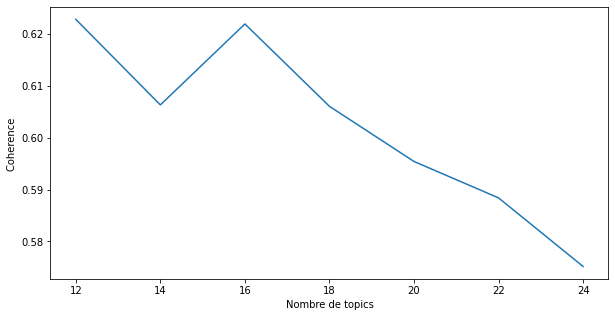

In [60]:
# affichage du graphe associé à la recherche du nombre de topics
plt.figure(figsize=(10,5))
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de topics")
plt.ylabel("Coherence ")
#plt.legend(("Valeurs de cohérencescoherence_values"), loc='best')
plt.show()

Un nombre entre 20 et 21 topics semble être un bon compromis 

In [61]:
num_topics=21 # nombre de topics
num_words=50 # nombre de mots par topics


lda_model_all = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_all,
                           num_topics=num_topics,
                           id2word=dictionary_all,
                           chunksize=100,
                           workers=7, 
                            passes=10,
                            random_state=100,
                           eval_every = 1,
                           per_word_topics=True)


print ("Affichage des ",num_topics," différents topics pour le corpus BOW :\n")
for idx, topic in lda_model_all.print_topics(-1,num_words):
    print('Topic: {} Word: {}'.format(idx, topic))




Affichage des  21  différents topics pour le corpus BOW :

Topic: 0 Word: 0.059*"recommend" + 0.051*"minute" + 0.035*"hour" + 0.024*"still" + 0.022*"stay" + 0.021*"last" + 0.016*"white" + 0.015*"literally" + 0.014*"recently" + 0.013*"man" + 0.013*"phone" + 0.012*"couple" + 0.010*"stuff" + 0.010*"original" + 0.009*"use" + 0.008*"ever see" + 0.008*"cinema" + 0.008*"decision" + 0.008*"flop" + 0.008*"super" + 0.007*"bad film" + 0.007*"chinese" + 0.006*"website" + 0.006*"buy product" + 0.005*"film" + 0.005*"dead" + 0.005*"know make" + 0.005*"produce" + 0.004*"helpful" + 0.004*"drag" + 0.004*"never cease" + 0.003*"charge" + 0.003*"new" + 0.003*"hero" + 0.003*"waste time" + 0.003*"luck" + 0.003*"movie seem" + 0.003*"agree" + 0.003*"freedom" + 0.003*"really funny" + 0.003*"high" + 0.003*"load" + 0.003*"good protection" + 0.003*"problem" + 0.003*"arrive" + 0.003*"holster" + 0.003*"defective" + 0.003*"energy" + 0.003*"hold charge" + 0.003*"last long"
Topic: 1 Word: 0.054*"way" + 0.041*"feel" + 0

Pour chaque document, nous pouvons donc rechercher le topic dominant : 

In [62]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_all, corpus=corpus_all, texts=df_all.sentence)


display(df_topic_sents_keywords)

,topic_dominant,pourcentage_contrib,topic_keywords,sentence
0,7.0,0.6730,"go, much, menu, top, disgusting, wrong, money,...",So there is no way for me to plug it in here i...
1,9.0,0.3362,"good, even, order, get, bland, find, phone, st...","Good case, Excellent value."
2,19.0,0.3807,"back, need, little, hand, waste, old, area, ch...",Great for the jawbone.
3,18.0,0.8639,"great, also, ever, give, lack, item, movie, co...",Tied to charger for conversations lasting more...
4,18.0,0.3492,"great, also, ever, give, lack, item, movie, co...",The mic is great.
...,...,...,...,...
2995,8.0,0.3492,"film, think, lot, cast, acting, easy, weak, sc...",I think food should have flavor and texture an...
2996,7.0,0.5238,"go, much, menu, top, disgusting, wrong, money,...",Appetite instantly gone.
2997,0.0,0.0476,"recommend, minute, hour, still, stay, last, wh...",Overall I was not impressed and would not go b...
2998,9.0,0.5238,"good, even, order, get, bland, find, phone, st...","The whole experience was underwhelming, and I ..."


In [63]:
# modification du dataframe pour intégrer les mots associés au topic dominant à chaque document
df_all['keywords']=df_topic_sents_keywords['topic_keywords']
display(df_all)

,sentence,sentiment,source,keywords
0,So there is no way for me to plug it in here i...,0,amazon,"go, much, menu, top, disgusting, wrong, money,..."
1,"Good case, Excellent value.",1,amazon,"good, even, order, get, bland, find, phone, st..."
2,Great for the jawbone.,1,amazon,"back, need, little, hand, waste, old, area, ch..."
3,Tied to charger for conversations lasting more...,0,amazon,"great, also, ever, give, lack, item, movie, co..."
4,The mic is great.,1,amazon,"great, also, ever, give, lack, item, movie, co..."
...,...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp,"film, think, lot, cast, acting, easy, weak, sc..."
2996,Appetite instantly gone.,0,yelp,"go, much, menu, top, disgusting, wrong, money,..."
2997,Overall I was not impressed and would not go b...,0,yelp,"recommend, minute, hour, still, stay, last, wh..."
2998,"The whole experience was underwhelming, and I ...",0,yelp,"good, even, order, get, bland, find, phone, st..."


Il reste juste à appliquer une classification supervisée mais en considérant à présent les mots clés associés aux topics. Le code ci-dessous illustre le principe. Bien entendu il faudrait faire une cross validation, une recherche du meilleur classifieur ... comme nous l'avons vu dans le notebook "Classification de données textuelles"

In [64]:

# selection des données
X=df_all.keywords
y=df_all.sentiment

# Création d'un jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# création du pipeline en ajoutant le classifier
pipe = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                 ("SVM", SVC())])
pipe.fit(X_train,y_train)


y_true, y_pred = y_test, pipe.predict(X_test)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.61      0.56       454
           1       0.51      0.42      0.46       446

    accuracy                           0.51       900
   macro avg       0.51      0.51      0.51       900
weighted avg       0.51      0.51      0.51       900



<font color=red>Exercice :</font> dans les cellules ci-dessus, faites varier le nombre de topics ainsi que le nombre de mots pour voir si vous pouvez améliorer la classification. 


## **Un dernier exercice pour terminer** 



Le 16 mars 2020, l'Institut Allen pour l'IA (AI2), en collaboration avec la Maison Blanche (OSTP), la Bibliothèque nationale de médecine (NLM), l'Initiative Chan Zuckerburg (CZI) , Microsoft Research et Kaggle, coordonnés par le Center for Security and Emerging Technology (CSET) de l'Université de Georgetown, ont publié la première version de d'un jeu de données appelé : CORD-19.  

CORD-19 est une collection de publications et de pré-impressions sur la Covid-19 et les coronavirus historiques associés (e.g. le SRAS et le MERS). L'objectif est de connecter la communauté d'apprentissage automatique avec des experts du domaine biomédical et des décideurs politiques pour aider à mieux comprendre le virus et à identifier des traitements efficaces pour Covid-19.  

Les données sont mises à jour régulièrement et de plus amples informations sont disponibles ici : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/

Kaggle propose ainsi un challenge : https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=570 

<font color=red>Exercice :</font> l'objectif ici est d'utiliser des données du challenge (des articles de recherche) et de rechercher les topics qui sont présents d'abord dans le titre puis après dans le texte afin de les visualiser. 
Pour cela vous pourrez récupérer le corpus ici : 


In [ ]:
!wget https://www.lirmm.fr/~poncelet/Ressources/clean_noncomm_use.csv

--2023-02-13 13:18:58--  https://www.lirmm.fr/~poncelet/Ressources/clean_noncomm_use.csv
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147732912 (141M) [text/csv]
Saving to: ‘clean_noncomm_use.csv’

clean_noncomm_use.c  67%[============>       ]  95.19M   311KB/s    eta 1m 40s 

Ce corpus est un petit sous-ensemble extrait du challenge Kaggle. La transformation en csv a été réalisée par : https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv?select=clean_pmc.csv 

Pour le lire il suffit d'exécuter la cellule suivante.  

**Remarque :** les articles biomédicaux ont souvent une structure particulière avec des mots clés définis (e.g. 'Introduction', 'materials','methods','results',...) qui peuvent sans doute être ajoutés dans les stopwords. De plus, vous verrez qu'il y a beaucoup de bruits (e.g. 'creativecommons','license','http', etc.) et une première analyse des données en appliquant ce qui a été vu dans le notebook "2 - Ingénierie des données textuelles" pourrait vous aider à supprimer des mots inutiles.

**Remarque :** attention les articles peuvent être très longs aussi si vous ne souhaitez pas attendre trop longtemps les pré-traitements et l'obtention du modèle pour extraire les topics à partir du texte, vous pouvez prendre un sous-ensemble de 500 articles. Pour prendre un sous ensemble de 500 :   
df=df.sample(n=500, replace=True, random_state=1)  
df.reset_index(drop=True, inplace=True)  

In [66]:
# lecture du fichier
df_covid = pd.read_csv("clean_noncomm_use.csv", encoding='utf8')

# taille du fichier
print (df_covid.shape)

# les premières lignes
display (df_covid)


(2489, 9)


,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,cd92f91038067e7a10aa27d676ce696e1e4d67ce,EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyl...,"Zhen-Hong Zhu, Wen-Qi Song, Chang-Qing Zhang, ...","Zhen-Hong Zhu (Shanghai Jiao Tong University, ...",Abstract\n\nMesenchymal stem cells have been w...,Introduction\n\nOsteonecrosis of the femoral h...,Avascular necrosis of the femoral head: Vascul...,"[{'first': 'Zhen-Hong', 'middle': [], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Avascul..."
1,bab279da548d8bd363acd5033e9dc54e7dbb7107,Effects of school breaks on influenza- like il...,"Yanhui Chu, Zhenyu Wu, Jiayi Ji, Jingyi Sun, X...","Yanhui Chu, Zhenyu Wu (Fudan University, Shang...",NaN,INTRODUCTION\n\nSchoolchildren play a major ro...,Estimating household and community transmissio...,"[{'first': 'Yanhui', 'middle': [], 'last': 'Ch...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Estimat..."
2,71edbd57cdd9af956a12054932e0cbdb87ce1fea,Social Network Characteristics and Body Mass I...,"Won Joon Lee, Yoosik Youm, Yumie Rhee, Yeong-R...",Won Joon Lee (Yonsei University College of Med...,Abstract\n\nResearch has shown that obesity ap...,INTRODUCTION\n\nThe study of the effects of so...,The contribution of the social environment to ...,"[{'first': 'Won', 'middle': ['Joon'], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The con..."
3,2dfdbf2d6b77426866feaf93486327d372fd27c7,CLINICAL EXPERIMENTAL VACCINE RESEARCH,NaN,NaN,NaN,\n\nThere may be many reasons for the signific...,"A short history of vaccination, S L Plotkin, S...",[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'A short..."
4,0afa3ea846396533c7ca515968abcfea3f895082,Bone Marrow Dendritic Cells from Mice with an ...,"Stacey L Burgess, Erica Buonomo, Maureen Carey...",Stacey L Burgess (Johns Hopkins Bloomberg Scho...,Abstract\n\nThere is an emerging paradigm that...,\n\nport neutrophil infiltration in inflammato...,WHO/PAHO informal consultation on intestinal p...,"[{'first': 'Stacey', 'middle': ['L'], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'WHO/PAH..."
...,...,...,...,...,...,...,...,...,...
2484,3b8b2a835cfa770c6cef711d52e1f1e869d8aca8,Tumor-Treating Fields Induce RAW264.7 Macropha...,"Jeong-In Park, Kyung-Hee Song, Seung-Youn Jung...","Jeong-In Park, Kyung-Hee Song, Seung-Youn Jung...",Abstract\n\nObjective: Tumor-treating fields a...,Introduction\n\nTumor-treating fields (TTFs) t...,NovoTTF-100A versus physician's choice chemoth...,"[{'first': 'Jeong-In', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': ""NovoTTF..."
2485,500e585afac01e4b3847aa138db86b04352484c5,Efficacy and safety of Chou-Ling-Dan granules ...,"Jiayang He, Zhengtu Li, Wanyi Huang, Wenda Gua...","Jiayang He, Zhengtu Li, Wanyi Huang, Wenda Gua...",NaN,\n\nIntroduction Chou-Ling-Dan (CLD) (Laggerap...,Effect of the epidemiological heterogeneity on...,"[{'first': 'Jiayang', 'middle': [], 'last': 'H...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Effect ..."
2486,87f178ed1bcc5a747200ccd4adf42d883afd9fb7,Complete Genome Sequences of the SARS-CoV: the...,"Shengli Bi, E&apos;de Qin, Zuyuan Xu, Wei Li,...","Shengli Bi, E&apos;de Qin (Chinese Academy of...",Abstract\n\nBeijing has been one of the epicen...,\n\nAccumulated number of probable cases and d...,Ile(16)/Leu(1) 214 (7.5) 26.6-27.1 43.5-43.9 (...,"[{'first': 'Shengli', 'middle': [], 'last': 'B...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Ile(16)..."
2487,5d4f1f02d0e731966dddd635e8fa7bfdc169d3b9,Case Report A Rare Case of Autoimmune Polyglan...,"Ryan Kenneth Smith, Beaumont Health, Peter M G...","Ryan Kenneth Smith, Beaumont Health, Peter M G...","Abstract\n\nAdrenal insufficiency is a rare, p...",Introduction\n\nAdrenal insufficiency is decre...,"Adrenal insufficiency, E Charmandari, N C Nico...","[{'first': 'Ryan', 'middle': ['Kenneth'], 'las...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Adrenal..."


<font color=Blue>Solution :</font> 

In [67]:
# il suffit d'appliquer les principes précédents sur le titre et le texte
########### cas des titres

# selection du titre
df_title=df_covid['title'].copy()

print (df_title.shape)
display(df_title)

stop = stopwords.words('english')

# enrichissement des stopwords 
stop.extend(['always','try','go','get','make','would','really',
                  'like','came','got','article','creativecommons','license','http'])
corpus, corpus_tfidf, dictionary, bigram_token=MyCleanTextsforLDA(df_title)


num_topics=10 # nombre de topics
num_words=10 # nombre de mots par topics


lda_model_covid_tfidf = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_tfidf,
                           num_topics=num_topics,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, 
                           passes=10,
                           random_state=100,
                           eval_every = 1,
                           per_word_topics=True)

print ("Affichage des ",num_topics," différents topics pour le corpus TF-IDF :")

for idx, topic in lda_model_covid_tfidf.print_topics(-1,num_words):
    print('Topic : {} Words : {}'.format(idx, topic))

coherence_model_lda_tfidf = CoherenceModel(model=lda_model_covid_tfidf, texts=bigram_token, dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda_tfidf.get_coherence()
print('Cohérence  : ', coherence_lda)

print('Perplexité : ', lda_model_covid_tfidf.log_perplexity(corpus_tfidf))  


visu_data_title = gensimvis.prepare(lda_model_covid_tfidf, corpus, dictionary)
pyLDAvis.display(visu_data_title)

(2489,)


0       EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyl...
1       Effects of school breaks on influenza- like il...
2       Social Network Characteristics and Body Mass I...
3                  CLINICAL EXPERIMENTAL VACCINE RESEARCH
4       Bone Marrow Dendritic Cells from Mice with an ...
                              ...                        
2484    Tumor-Treating Fields Induce RAW264.7 Macropha...
2485    Efficacy and safety of Chou-Ling-Dan granules ...
2486    Complete Genome Sequences of the SARS-CoV: the...
2487    Case Report A Rare Case of Autoimmune Polyglan...
2488    Factors influencing Dipylidium sp. infection i...
Name: title, Length: 2489, dtype: object

Affichage des  10  différents topics pour le corpus TF-IDF :
Topic : 0 Words : 0.004*"viral" + 0.003*"protein" + 0.003*"virus" + 0.003*"access" + 0.003*"evolution" + 0.003*"current" + 0.003*"induce" + 0.003*"full paper" + 0.003*"vaccine" + 0.003*"respiratory failure"
Topic : 1 Words : 0.018*"license" + 0.017*"creativecommon org" + 0.015*"license http" + 0.005*"overview" + 0.004*"age" + 0.003*"structure" + 0.003*"southern" + 0.003*"respiratory virus" + 0.003*"countermeasure" + 0.003*"ribosomal"
Topic : 2 Words : 0.010*"case report" + 0.009*"infection chemotherapy" + 0.004*"avian influenza" + 0.004*"base" + 0.003*"virus" + 0.003*"hepatitis virus" + 0.003*"development" + 0.003*"use" + 0.003*"systematic review" + 0.003*"specie"
Topic : 3 Words : 0.007*"respiratory syndrome" + 0.005*"support information" + 0.005*"outbreak" + 0.004*"mer cov" + 0.004*"lung" + 0.003*"mediate" + 0.003*"coronavirus outbreak" + 0.003*"characteristic" + 0.003*"acute respiratory" + 0.003*"case report"
Topic : 4 Wor

(2489,)


0       Introduction\n\nOsteonecrosis of the femoral h...
1       INTRODUCTION\n\nSchoolchildren play a major ro...
2       INTRODUCTION\n\nThe study of the effects of so...
3       \n\nThere may be many reasons for the signific...
4       \n\nport neutrophil infiltration in inflammato...
                              ...                        
2484    Introduction\n\nTumor-treating fields (TTFs) t...
2485    \n\nIntroduction Chou-Ling-Dan (CLD) (Laggerap...
2486    \n\nAccumulated number of probable cases and d...
2487    Introduction\n\nAdrenal insufficiency is decre...
2488    Introduction\n\nThe adult form of Dipylidium c...
Name: text, Length: 2489, dtype: object

après tirage de 500 articles au hasard 
(500,)


0      Introduction\n\nAs of 2009, the overall nation...
1      Introduction\n\nThe newly discovered novel cor...
2      \n\nTranslation is a tightly regulated step of...
3      \n\nIn June 2012, a patient with a severe resp...
4      INTRODUCTION\n\nAutophagy is an essential proc...
                             ...                        
495    Introduction\n\nPorcine epidemic diarrhoea vir...
496    \n\nEncephalitozoon cuniculi (E. cuniculi) is ...
497    \n\nFowler Ⅲ AA et al . Intravenous vitamin C ...
498    Introduction\n\nRecently several lines of evid...
499    Introduction\n\nCommunity-based studies are an...
Name: text, Length: 500, dtype: object

Affichage des  10  différents topics pour le corpus TF-IDF :
Topic : 0 Words : 0.000*"antibiotic resistance" + 0.000*"synthetic biology" + 0.000*"autophagy" + 0.000*"dwell time" + 0.000*"phage" + 0.000*"frameshift efficiency" + 0.000*"guanine mtase" + 0.000*"signature sequence" + 0.000*"vhh" + 0.000*"drug repositioning"
Topic : 1 Words : 0.000*"emergency care" + 0.000*"vero cell" + 0.000*"liver fibrosis" + 0.000*"suspension culture" + 0.000*"mastv" + 0.000*"glutamic acid" + 0.000*"treg" + 0.000*"cell" + 0.000*"patient" + 0.000*"protein code"
Topic : 2 Words : 0.000*"contact trace" + 0.000*"serial interval" + 0.000*"host protein" + 0.000*"severe fatal" + 0.000*"mild patient" + 0.000*"severe patient" + 0.000*"day cri" + 0.000*"viral particle" + 0.000*"live bird" + 0.000*"phever"
Topic : 3 Words : 0.001*"mer cov" + 0.001*"cell" + 0.000*"protein" + 0.000*"patient" + 0.000*"virus" + 0.000*"fig" + 0.000*"cat" + 0.000*"mer" + 0.000*"sequence" + 0.000*"figure"
Topic : 4 Words : 0.000*"confirm 

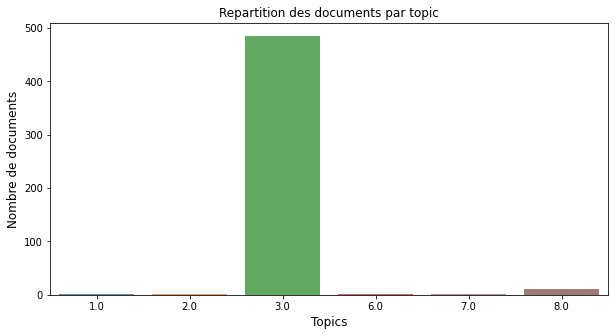

In [68]:
# Traitement du texte
# selection du texte
df_text=df_covid['text'].copy()

print (df_text.shape)
display(df_text)
# selection d'un echantillon de 500 articles
df_text=df_text.sample(n=500, replace=True, random_state=1)
print ("après tirage de 500 articles au hasard ")
df_text.reset_index(drop=True, inplace=True)
print (df_text.shape)
display(df_text)

stop = stopwords.words('english')

# enrichissement des stopwords 
stop.extend(['always','try','go','get','make','would','really',
                  'like','came','got','article','introduction','materials','methods',
             'results','creativecommons','license','http', 'fig','figure'])


corpus, corpus_tfidf, dictionary, bigram_token=MyCleanTextsforLDA(df_text)


num_topics=10 # nombre de topics
num_words=10 # nombre de mots par topics


lda_model_covid_tfidf = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus_tfidf,
                           num_topics=num_topics,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, 
                           passes=10,
                           random_state=100,
                           eval_every = 1,
                           per_word_topics=True)

print ("Affichage des ",num_topics," différents topics pour le corpus TF-IDF :")

for idx, topic in lda_model_covid_tfidf.print_topics(-1,num_words):
    print('Topic : {} Words : {}'.format(idx, topic))

coherence_model_lda_tfidf = CoherenceModel(model=lda_model_covid_tfidf, texts=bigram_token, dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda_tfidf.get_coherence()
print('Cohérence  : ', coherence_lda)

print('Perplexité : ', lda_model_covid_tfidf.log_perplexity(corpus_tfidf))  


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_covid_tfidf, corpus=corpus, texts=df_text)

# nombre de documents par topics
topic_counts = df_topic_sents_keywords['topic_dominant'].value_counts()

# affichage
plt.figure(figsize=(10,5))
ax=sns.barplot(x=topic_counts.index,y=topic_counts.values,  alpha=0.8)
plt.title('Repartition des documents par topic')
plt.ylabel('Nombre de documents', fontsize=12)
plt.xlabel('Topics', fontsize=12)
plt.show()

visu_data_text = gensimvis.prepare(lda_model_covid_tfidf, corpus, dictionary)
pyLDAvis.display(visu_data_text)